In [ ]:
!wget --no-check-certificate \
 https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
 -O /content/catsdogs.zip

--2023-08-23 15:57:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.128, 142.251.171.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/catsdogs.zip’

/content/catsdogs.z 100%[===================>]  65.43M   221MB/s    in 0.3s    

2023-08-23 15:57:39 (221 MB/s) - ‘/content/catsdogs.zip’ saved [68606236/68606236]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:

train_dir = 'Magnesium/train'
validation_dir = 'Magnesium/valid'

# Import the required modules and load the training and validation set

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir,shuffle=True,batch_size=32,image_size=(256, 256))
val_dataset = image_dataset_from_directory(validation_dir,shuffle=True,batch_size=32,image_size=(256,256))

Found 1306 files belonging to 2 classes.
Found 510 files belonging to 2 classes.


# Data Preprocessing

Data Augmentation

In [3]:
data_augmentation = keras.Sequential([
 keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
 keras.layers.experimental.preprocessing.RandomRotation(0.1),
 ]
 )

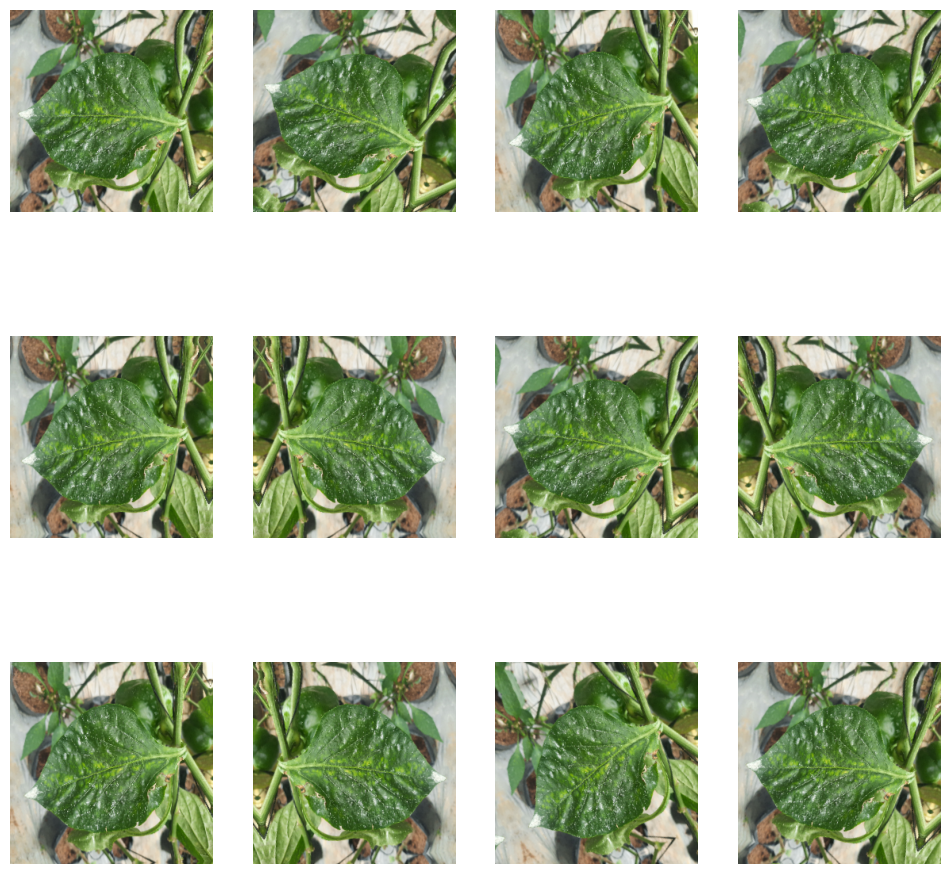

In [4]:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
  plt.figure(figsize=(12, 12))
  first_image = images[0]
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    augmented_image = data_augmentation(
    tf.expand_dims(first_image, 0)
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

# Create the base model from the Xceptional model

In [5]:
base_model = keras.applications.Xception(
 weights='imagenet',
 input_shape=(256, 256, 3),
 include_top=False)

In [6]:
base_model.trainable = False

# Create the final dense layer

In [7]:
inputs = keras.Input(shape=(256, 256, 3))

In [8]:
x = data_augmentation(inputs)

In [9]:
x = tf.keras.applications.xception.preprocess_input(x)

In [10]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [11]:
print("Number of layers in the base model:", len(base_model.layers))

Number of layers in the base model: 132


# Train the model

In [12]:
model.compile(optimizer='adam',
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())
history=model.fit(training_set, epochs=20, validation_data=val_dataset)

Epoch 1/20
41/41 [==============================] - 97s 2s/step - loss: 0.5464 - binary_accuracy: 0.6807 - val_loss: 0.3376 - val_binary_accuracy: 0.9020
Epoch 2/20
41/41 [==============================] - 91s 2s/step - loss: 0.3278 - binary_accuracy: 0.8668 - val_loss: 0.2279 - val_binary_accuracy: 0.9294
Epoch 3/20
41/41 [==============================] - 91s 2s/step - loss: 0.2416 - binary_accuracy: 0.9135 - val_loss: 0.1783 - val_binary_accuracy: 0.9431
Epoch 4/20
41/41 [==============================] - 98s 2s/step - loss: 0.2143 - binary_accuracy: 0.9204 - val_loss: 0.1577 - val_binary_accuracy: 0.9373
Epoch 5/20
41/41 [==============================] - 93s 2s/step - loss: 0.1886 - binary_accuracy: 0.9319 - val_loss: 0.1395 - val_binary_accuracy: 0.9588
Epoch 6/20
41/41 [==============================] - 88s 2s/step - loss: 0.1694 - binary_accuracy: 0.9510 - val_loss: 0.1278 - val_binary_accuracy: 0.9529
Epoch 7/20
41/41 [==============================] - 87s 2s/step - loss: 0.15

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [14]:
predictions = model.predict(val_dataset)
# Assuming your model outputs logits, you can convert them to class labels
predicted_labels = np.round(tf.sigmoid(predictions))


16/16 [==============================] - 26s 1s/step


In [15]:
true_labels = []
for _, label in val_dataset:
    true_labels.extend(label.numpy())
true_labels = np.array(true_labels)


In [16]:
cm = confusion_matrix(true_labels, predicted_labels)

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["MagnesiumInitial", "MagnesiumSevere"])


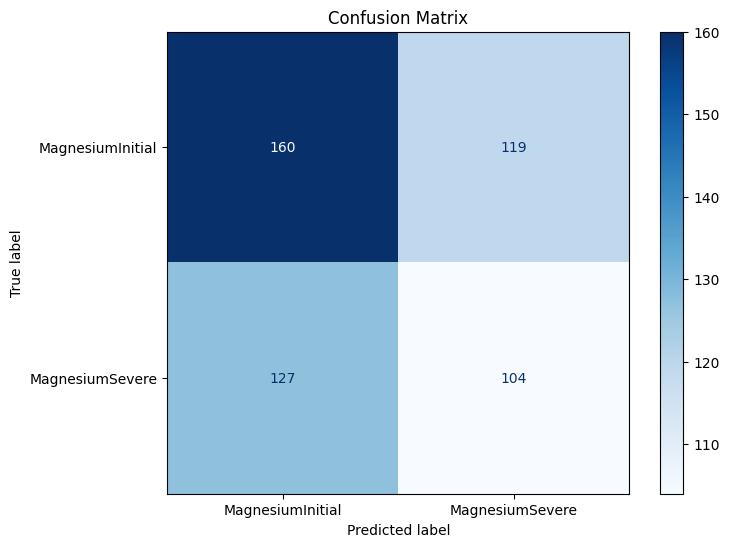

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()


Check accuracy

Training Accuracy: 0.9701378345489502
Validation Accuracy: 0.970588207244873


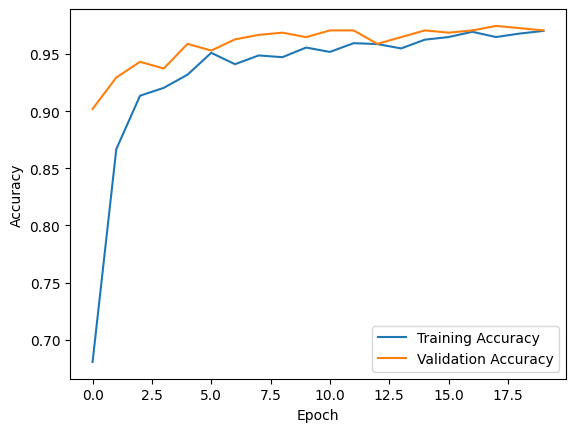

In [19]:
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Fine tuning

In [20]:
base_model.trainable = True

fine_tune_from = 70

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

history_fine_tune = model.fit(training_set, epochs=10, validation_data=val_dataset)



Epoch 1/10
41/41 [==============================] - 301s 7s/step - loss: 0.1487 - binary_accuracy: 0.9410 - val_loss: 0.0230 - val_binary_accuracy: 0.9863
Epoch 2/10
41/41 [==============================] - 289s 7s/step - loss: 0.0144 - binary_accuracy: 0.9962 - val_loss: 0.0103 - val_binary_accuracy: 0.9941
Epoch 3/10
41/41 [==============================] - 267s 6s/step - loss: 0.0063 - binary_accuracy: 0.9985 - val_loss: 0.0069 - val_binary_accuracy: 0.9961
Epoch 4/10
41/41 [==============================] - 267s 6s/step - loss: 0.0010 - binary_accuracy: 1.0000 - val_loss: 0.0047 - val_binary_accuracy: 0.9980
Epoch 5/10
41/41 [==============================] - 267s 6s/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 0.0069 - val_binary_accuracy: 0.9980
Epoch 6/10
41/41 [==============================] - 266s 6s/step - loss: 0.0117 - binary_accuracy: 0.9962 - val_loss: 0.0032 - val_binary_accuracy: 1.0000
Epoch 7/10
41/41 [==============================] - 270s 6s/step - los

Fine-Tuning Training Accuracy: 0.9954057931900024
Fine-Tuning Validation Accuracy: 0.9921568632125854


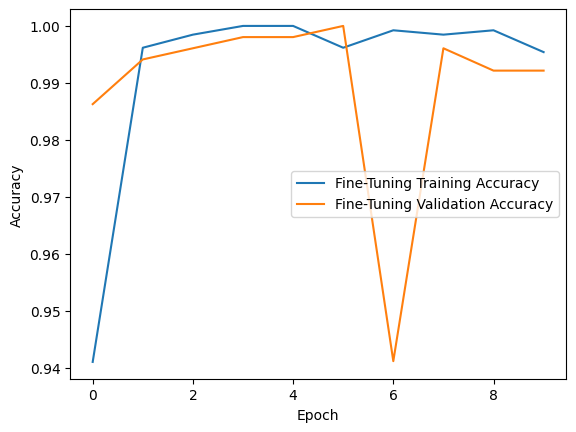

In [21]:

fine_tune_train_accuracy = history_fine_tune.history['binary_accuracy']
fine_tune_val_accuracy = history_fine_tune.history['val_binary_accuracy']

print("Fine-Tuning Training Accuracy:", fine_tune_train_accuracy[-1])
print("Fine-Tuning Validation Accuracy:", fine_tune_val_accuracy[-1])

plt.plot(fine_tune_train_accuracy, label='Fine-Tuning Training Accuracy')
plt.plot(fine_tune_val_accuracy, label='Fine-Tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()